In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def load_data(filename):
    data = pd.read_csv(filename, skiprows=6, sep=' ', names=['index', 'x', 'y'], skipfooter=1, engine='python')
    return data.set_index('index')

def euclidean_distance(p1, p2):
    return round(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def calculate_distance_matrix(coords):
    size = coords.shape[0]
    matrix = np.zeros((size, size), dtype=int)
    coords_values = coords.values
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = euclidean_distance(coords_values[i], coords_values[j])
            else:
                matrix[i][j] = 0
    return matrix

In [3]:
def plot_cycles(coords, cycle1, cycle2, title = 'Visualization of Two Cycles'):
    x_coords, y_coords = coords['x'].values, coords['y'].values

    plt.figure(figsize=(10, 8))
    
    # Plot cycle1
    x1 = [x_coords[i] for i in cycle1]
    y1 = [y_coords[i] for i in cycle1]
    plt.plot(x1, y1, 'ro-', label='Cycle 1')

    # Plot cycle2
    x2 = [x_coords[i] for i in cycle2]
    y2 = [y_coords[i] for i in cycle2]
    plt.plot(x2, y2, 'bo-', label='Cycle 2')

    plt.scatter(x_coords, y_coords, color='gray', zorder=3)
    
    for i in range(len(x_coords)):
        plt.annotate(str(i), (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

## Najbliższy sąsiad (nearest neighbor)
Poniżej znajduje się rozwiązanie dla heurystyki najbliższego sąsiada

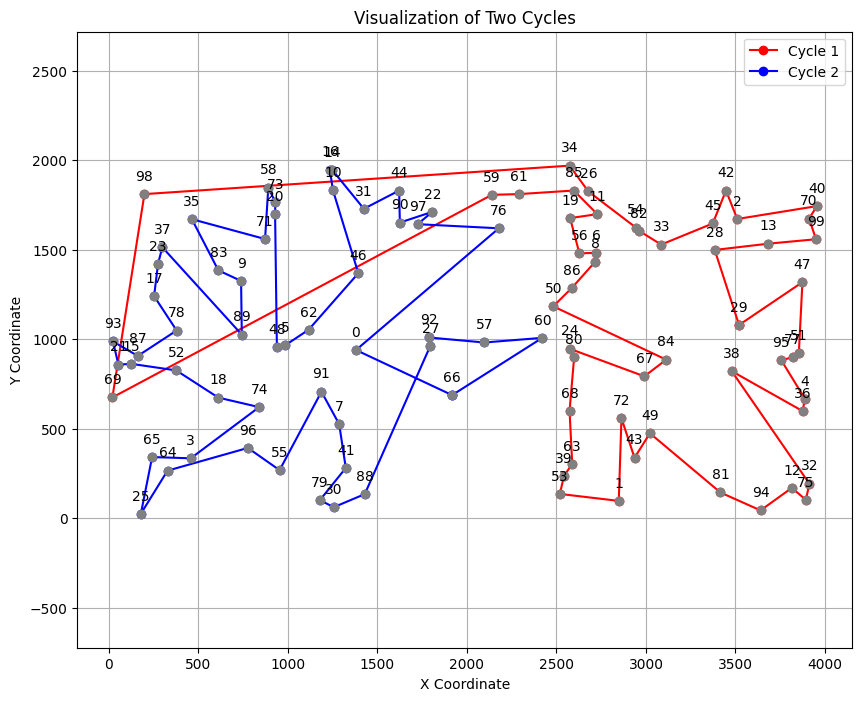

Cycle 1: [29, 47, 51, 77, 95, 4, 36, 38, 32, 75, 12, 94, 81, 49, 43, 72, 1, 53, 39, 63, 68, 80, 24, 67, 84, 50, 86, 8, 6, 56, 19, 11, 85, 61, 59, 69, 98, 34, 26, 54, 82, 33, 45, 42, 2, 40, 70, 99, 13, 28, 29]
Cycle 2: [66, 60, 57, 92, 27, 88, 30, 79, 41, 7, 91, 55, 96, 64, 25, 65, 3, 74, 18, 52, 15, 21, 93, 87, 78, 17, 23, 37, 89, 9, 83, 35, 71, 58, 73, 20, 48, 5, 62, 46, 10, 16, 14, 31, 44, 90, 22, 97, 76, 0, 66]


In [4]:
def initialize_two_cycles(coords):
    n = len(coords)
    start1 = random.randint(0, n-1)
    start2 = random.randint(0, n-1)
    while start2 == start1:
        start2 = random.randint(0, n-1)
    return [start1], [start2], set([start1, start2])

def nearest_neighbor(coords, distance_matrix):
    cycle1, cycle2, visited = initialize_two_cycles(coords)
    total_vertices = len(coords)
    target_size = (total_vertices + 1) // 2

    while len(visited) < total_vertices:
        if len(cycle1) < target_size:
            cycle1 = insert_nearest_vertex(cycle1, visited, distance_matrix)

        if len(cycle2) < total_vertices // 2 and len(visited) < total_vertices:
            cycle2 = insert_nearest_vertex(cycle2, visited, distance_matrix)
    
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    return cycle1, cycle2

def insert_nearest_vertex(cycle, visited, distance_matrix):
    last_vertex = cycle[-1]
    nearest_vertex = None
    best_increase = float('inf')
    best_position = None
    min_distance = float('inf')

    for vertex in range(len(distance_matrix)):
        if vertex not in visited and distance_matrix[last_vertex][vertex] < min_distance:
            min_distance = distance_matrix[last_vertex][vertex]
            nearest_vertex = vertex

    if nearest_vertex is not None:
        for position in range(len(cycle)):
            increase = (distance_matrix[cycle[position]][nearest_vertex] + 
                        distance_matrix[nearest_vertex][cycle[(position + 1) % len(cycle)]] - 
                        distance_matrix[cycle[position]][cycle[(position + 1) % len(cycle)]])
            if increase < best_increase:
                best_increase = increase
                best_position = position + 1

    if nearest_vertex is not None:
        cycle.insert(best_position, nearest_vertex)
        visited.add(nearest_vertex)

    return cycle

filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'
coords_A = load_data(filename_kroA100)
coords_B = load_data(filename_kroB100)
distance_matrix_A = calculate_distance_matrix(coords_A)
cycle1, cycle2 = nearest_neighbor(coords_A, distance_matrix_A)
plot_cycles(coords_A, cycle1, cycle2)
print("Cycle 1:", cycle1)
print("Cycle 2:", cycle2)

## Rozbudowa cyklu (greedy cycle)

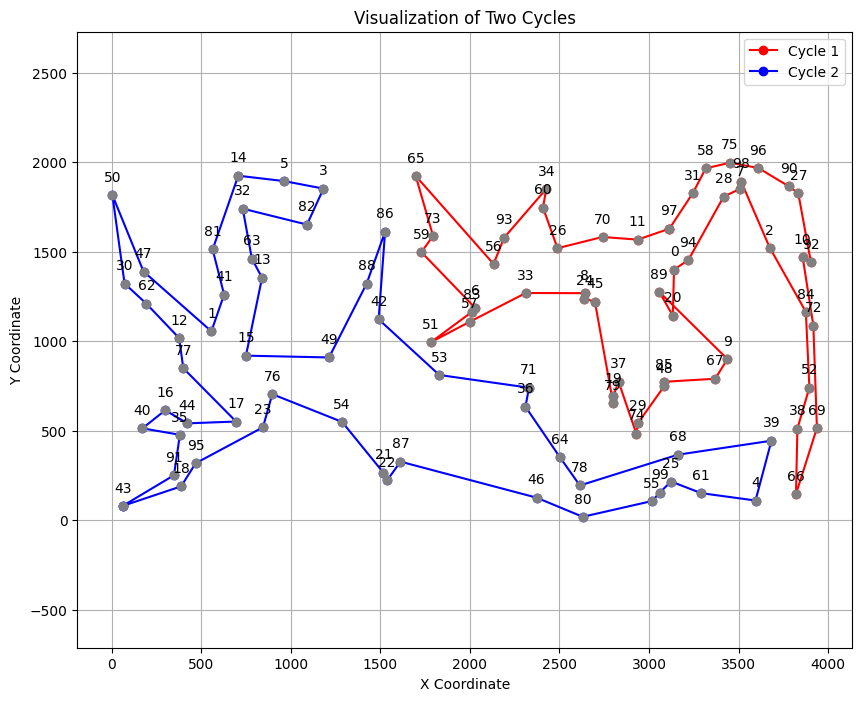

Cycle 1: [97, 11, 70, 26, 60, 34, 93, 56, 65, 73, 59, 6, 83, 51, 57, 33, 8, 24, 45, 79, 19, 37, 74, 29, 48, 85, 67, 9, 89, 20, 0, 94, 28, 7, 98, 2, 84, 52, 38, 66, 69, 72, 10, 92, 27, 90, 96, 75, 58, 31, 97]
Cycle 2: [43, 91, 35, 40, 16, 44, 17, 77, 12, 62, 30, 50, 47, 1, 41, 81, 14, 5, 3, 82, 32, 63, 13, 15, 49, 88, 86, 42, 53, 71, 36, 64, 78, 68, 39, 4, 61, 25, 99, 55, 80, 46, 87, 22, 21, 54, 76, 23, 95, 18, 43]


In [5]:
def initialize_two_greedy_cycles(distance_matrix):
    n = len(distance_matrix)
    start1 = random.randint(0, n-1)
    nearest1 = np.argmin([distance_matrix[start1][i] if i != start1 else np.inf for i in range(n)])
    cycle1 = [start1, nearest1, start1]
    visited = set([start1, nearest1])

    distances_to_start1 = [distance_matrix[start1][i] for i in range(n)]
    start2 = np.argmax(distances_to_start1)
    while start2 in visited:
        distances_to_start1[start2] = -np.inf
        start2 = np.argmax(distances_to_start1)
        
    nearest2 = np.argmin([distance_matrix[start2][i] if i != start2 and i not in visited else np.inf for i in range(n)])
    cycle2 = [start2, nearest2, start2]
    visited.update([start2, nearest2])

    return cycle1, cycle2, visited

def greedy_cycle_method(coords, distance_matrix):
    cycle1, cycle2, visited = initialize_two_greedy_cycles(distance_matrix)
    total_vertices = len(coords)

    while len(visited) < total_vertices:
        cycle1 = insert_best_vertex_greedy(cycle1, visited, distance_matrix)
        cycle2 = insert_best_vertex_greedy(cycle2, visited, distance_matrix)

    return cycle1, cycle2

def insert_best_vertex_greedy(cycle, visited, distance_matrix):
    best_increase = float('inf')
    best_vertex = None
    best_position = None

    for vertex in range(len(distance_matrix)):
        if vertex not in visited:
            for position in range(1, len(cycle) - 1):
                new_cycle = cycle[:position + 1] + [vertex] + cycle[position + 1:]
                increase = calculate_cycle_length(new_cycle, distance_matrix) - calculate_cycle_length(cycle, distance_matrix)
                if increase < best_increase:
                    best_increase = increase
                    best_vertex = vertex
                    best_position = position + 1

    if best_vertex is not None:
        cycle.insert(best_position, best_vertex)
        visited.add(best_vertex)

    return cycle

def calculate_cycle_length(cycle, distance_matrix):
    total_length = 0
    for i in range(len(cycle)):
        total_length += distance_matrix[cycle[i]][cycle[(i + 1) % len(cycle)]]
    return total_length

# Example usage
filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'
coords_A = load_data(filename_kroA100)
coords_B = load_data(filename_kroB100)
distance_matrix_A = calculate_distance_matrix(coords_A)
distance_matrix_B = calculate_distance_matrix(coords_B)
cycle1, cycle2 = greedy_cycle_method(coords_B, distance_matrix_B)
plot_cycles(coords_B, cycle1, cycle2)
print("Cycle 1:", cycle1)
print("Cycle 2:", cycle2)

## Heurystyka z 2-żalem (2-regret)

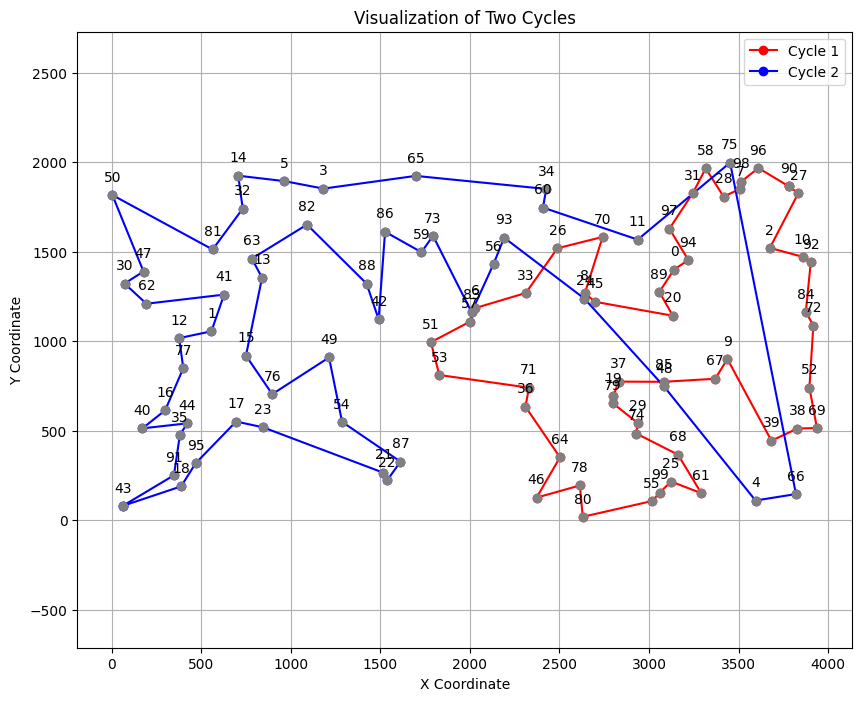

Cycle 1: [90, 96, 98, 7, 28, 58, 31, 97, 94, 0, 89, 20, 45, 8, 70, 26, 33, 6, 57, 51, 53, 71, 36, 64, 46, 78, 80, 55, 99, 25, 61, 68, 74, 29, 79, 19, 37, 85, 67, 9, 39, 38, 69, 52, 72, 84, 92, 10, 2, 27, 90] Length: 10172
Cycle 2: [43, 18, 95, 17, 23, 21, 22, 87, 54, 49, 76, 15, 13, 63, 82, 88, 42, 86, 59, 73, 83, 56, 93, 24, 48, 4, 66, 75, 11, 60, 34, 65, 3, 5, 14, 32, 81, 50, 47, 30, 62, 41, 1, 12, 77, 16, 40, 44, 35, 91, 43] Length: 18043
score: 28215


In [6]:
def insert_with_2_regret(cycle, visited, distance_matrix):
    insertions = []

    for vertex in range(len(distance_matrix)):
        if vertex not in visited:
            insertion_costs = []

            for position in range(1, len(cycle)):
                new_cycle = cycle[:position] + [vertex] + cycle[position:]
                cost_increase = calculate_cycle_length(new_cycle, distance_matrix) - calculate_cycle_length(cycle, distance_matrix)
                insertion_costs.append((cost_increase, position))

            if len(insertion_costs) >= 2:
                insertion_costs.sort()
                #print(insertion_costs)
                min_cost_1 = insertion_costs[0][0]
                min_cost_2 = insertion_costs[1][0]
                regret = min_cost_2 - min_cost_1
                weight = regret - 0.37*min_cost_1

                insertions.append((weight, vertex, insertion_costs[0][1]))

    insertions.sort(reverse=True)
    # print(insertions)

    if insertions:
        highest_regret = insertions[0]
        best_vertex = highest_regret[1]
        best_position = highest_regret[2]
        cycle.insert(best_position, best_vertex)
        visited.add(best_vertex)

    return cycle

def expand_cycles_with_2_regret(coords, distance_matrix):
    cycle1, cycle2, visited = initialize_two_greedy_cycles(distance_matrix)
    total_vertices = len(coords)

    while len(visited) < total_vertices:
        if len(visited) < total_vertices:
            cycle1 = insert_with_2_regret(cycle1, visited, distance_matrix)
        if len(visited) < total_vertices:
            cycle2 = insert_with_2_regret(cycle2, visited, distance_matrix)

    return cycle1, cycle2, calculate_cycle_length(cycle1, distance_matrix), calculate_cycle_length(cycle2, distance_matrix)

filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'
coords_A = load_data(filename_kroA100)
coords_B = load_data(filename_kroB100)
distance_matrix_A = calculate_distance_matrix(coords_A)
distance_matrix_B = calculate_distance_matrix(coords_B)
cycle1, cycle2, length1, length2 = expand_cycles_with_2_regret(coords_B, distance_matrix_B)
plot_cycles(coords_B, cycle1, cycle2)
print("Cycle 1:", cycle1, "Length:", length1)
print("Cycle 2:", cycle2 , "Length:", length2)
print("score:", length1 + length2)

# Eksperyment obliczeniowy

In [7]:
def run_experiments(filename, num_runs=100):
    coords = load_data(filename)
    distance_matrix = calculate_distance_matrix(coords)

    nn_lengths = []
    gc_lengths = []
    regret_lengths = []
    
    best_nn_cycle1, best_nn_cycle2 = None, None
    best_gc_cycle1, best_gc_cycle2 = None, None
    best_regret_cycle1, best_regret_cycle2 = None, None
    
    min_nn_length, min_gc_length, min_regret_length = float('inf'), float('inf'), float('inf')

    for _ in range(num_runs):
        # Nearest Neighbor
        cycle1, cycle2 = nearest_neighbor(coords, distance_matrix)
        length = calculate_cycle_length(cycle1, distance_matrix) + calculate_cycle_length(cycle2, distance_matrix)
        nn_lengths.append(length)
        if length < min_nn_length:
            min_nn_length = length
            best_nn_cycle1, best_nn_cycle2 = cycle1, cycle2

        # Greedy Cycle
        cycle1, cycle2 = greedy_cycle_method(coords, distance_matrix)
        length = calculate_cycle_length(cycle1, distance_matrix) + calculate_cycle_length(cycle2, distance_matrix)
        gc_lengths.append(length)
        if length < min_gc_length:
            min_gc_length = length
            best_gc_cycle1, best_gc_cycle2 = cycle1, cycle2

        # 2-Regret Heuristic
        cycle1, cycle2, length1, length2 = expand_cycles_with_2_regret(coords, distance_matrix)
        length = length1 + length2
        regret_lengths.append(length)
        if length < min_regret_length:
            min_regret_length = length
            best_regret_cycle1, best_regret_cycle2 = cycle1, cycle2

    nn_stats = (np.mean(nn_lengths), np.min(nn_lengths), np.max(nn_lengths), best_nn_cycle1, best_nn_cycle2, min_nn_length)
    gc_stats = (np.mean(gc_lengths), np.min(gc_lengths), np.max(gc_lengths), best_gc_cycle1, best_gc_cycle2, min_gc_length)
    regret_stats = (np.mean(regret_lengths), np.min(regret_lengths), np.max(regret_lengths), best_regret_cycle1, best_regret_cycle2, min_regret_length)

    return nn_stats, gc_stats, regret_stats

# Running experiments
filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'

nn_stats_A, gc_stats_A, regret_stats_A = run_experiments(filename_kroA100)
nn_stats_B, gc_stats_B, regret_stats_B = run_experiments(filename_kroB100)

# Prepare results table
results = {
    'Instance': ['kroA100', 'kroA100', 'kroA100', 'kroB100', 'kroB100', 'kroB100'],
    'Method': ['Nearest Neighbor', 'Greedy Cycle', '2-Regret', 'Nearest Neighbor', 'Greedy Cycle', '2-Regret'],
    'Mean': [nn_stats_A[0], gc_stats_A[0], regret_stats_A[0], nn_stats_B[0], gc_stats_B[0], regret_stats_B[0]],
    'Min': [nn_stats_A[1], gc_stats_A[1], regret_stats_A[1], nn_stats_B[1], gc_stats_B[1], regret_stats_B[1]],
    'Max': [nn_stats_A[2], gc_stats_A[2], regret_stats_A[2], nn_stats_B[2], gc_stats_B[2], regret_stats_B[2]]
}

results_df = pd.DataFrame(results)

# Save best cycles for plotting
best_cycles = {
    'kroA100_NearestNeighbor': (nn_stats_A[3], nn_stats_A[4], nn_stats_A[5]),
    'kroA100_GreedyCycle': (gc_stats_A[3], gc_stats_A[4], gc_stats_A[5]),
    'kroA100_2Regret': (regret_stats_A[3], regret_stats_A[4], regret_stats_A[5]),
    'kroB100_NearestNeighbor': (nn_stats_B[3], nn_stats_B[4], nn_stats_B[5]),
    'kroB100_GreedyCycle': (gc_stats_B[3], gc_stats_B[4], gc_stats_B[5]),
    'kroB100_2Regret': (regret_stats_B[3], regret_stats_B[4], regret_stats_B[5])
}


results_df = pd.DataFrame(results)
results_df

,Instance,Method,Mean,Min,Max
0,kroA100,Nearest Neighbor,30545.57,25491,39797
1,kroA100,Greedy Cycle,28788.26,24663,29980
2,kroA100,2-Regret,26710.91,22914,29510
3,kroB100,Nearest Neighbor,30674.03,26298,37496
4,kroB100,Greedy Cycle,28408.01,24992,30432
5,kroB100,2-Regret,27726.17,24172,29378


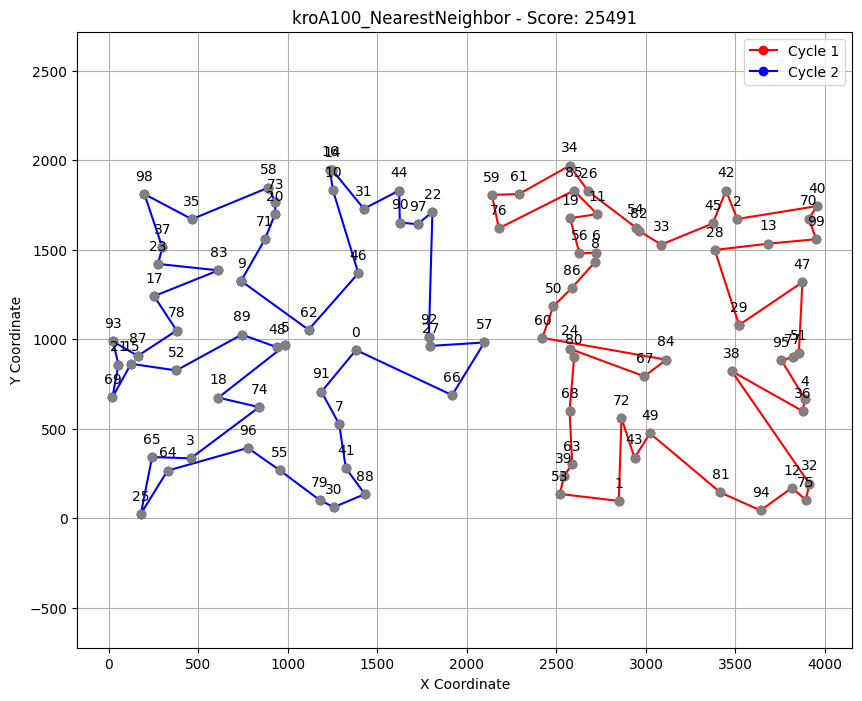

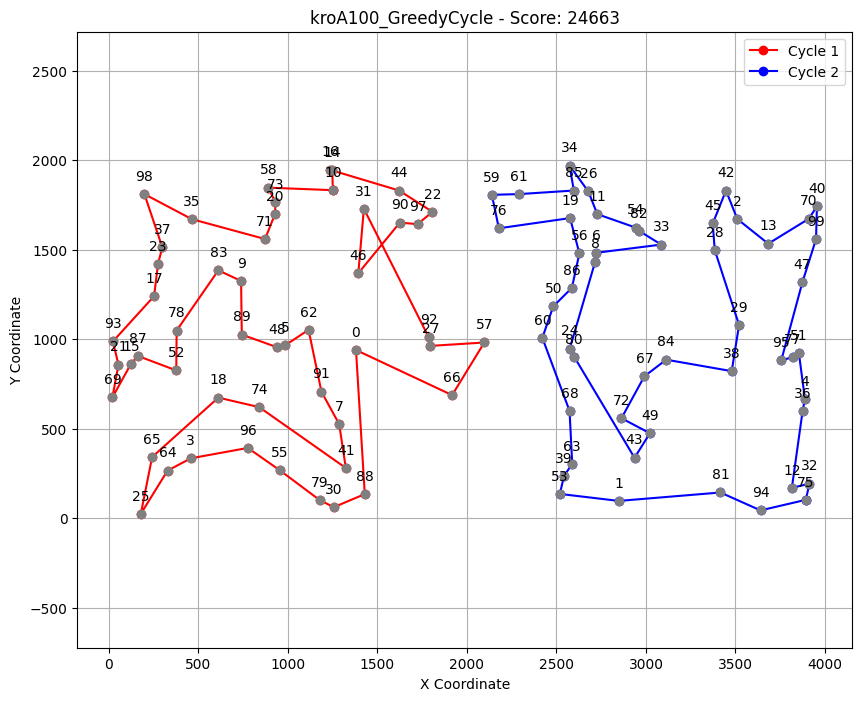

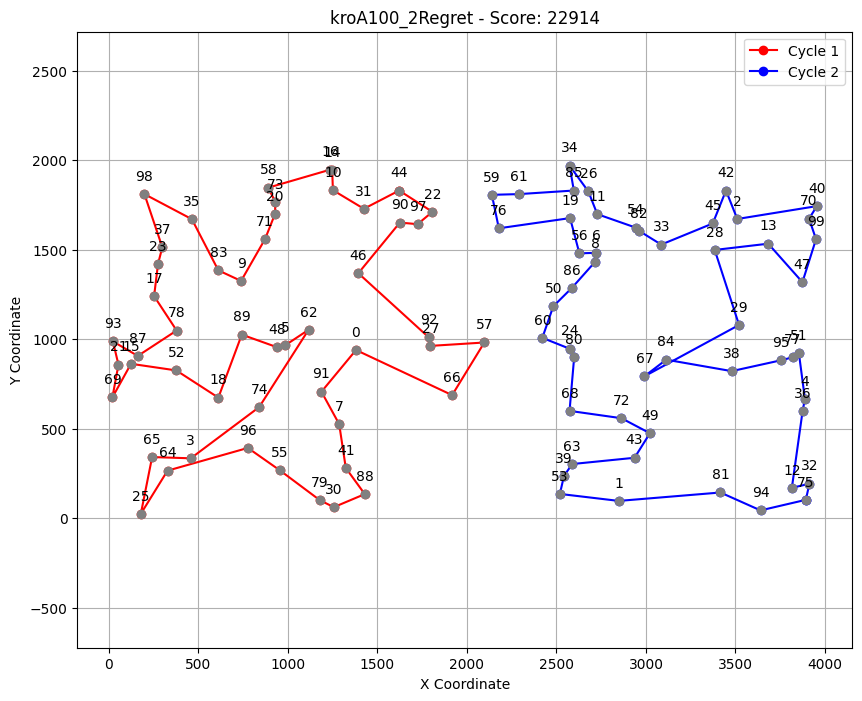

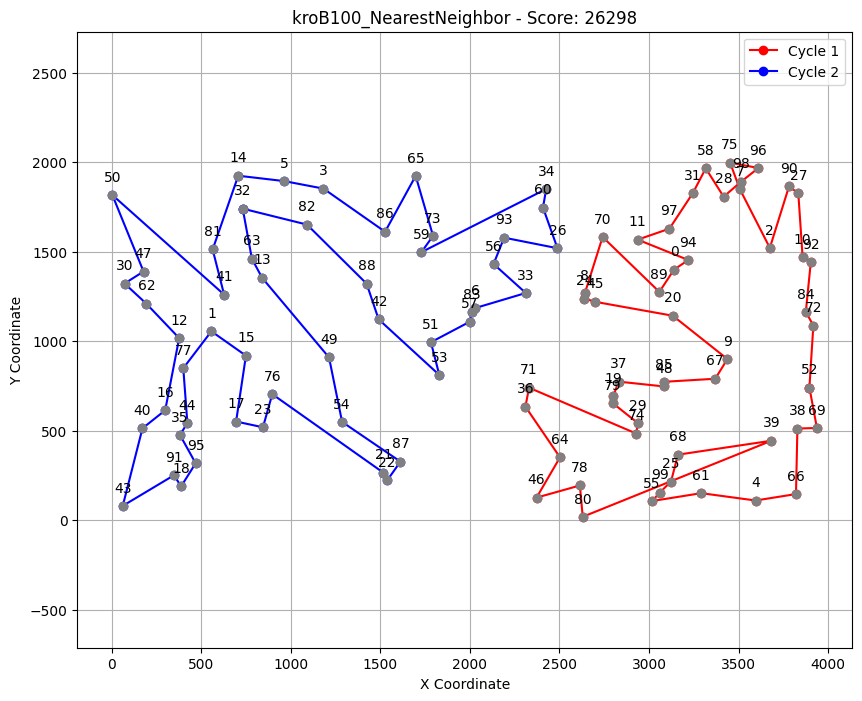

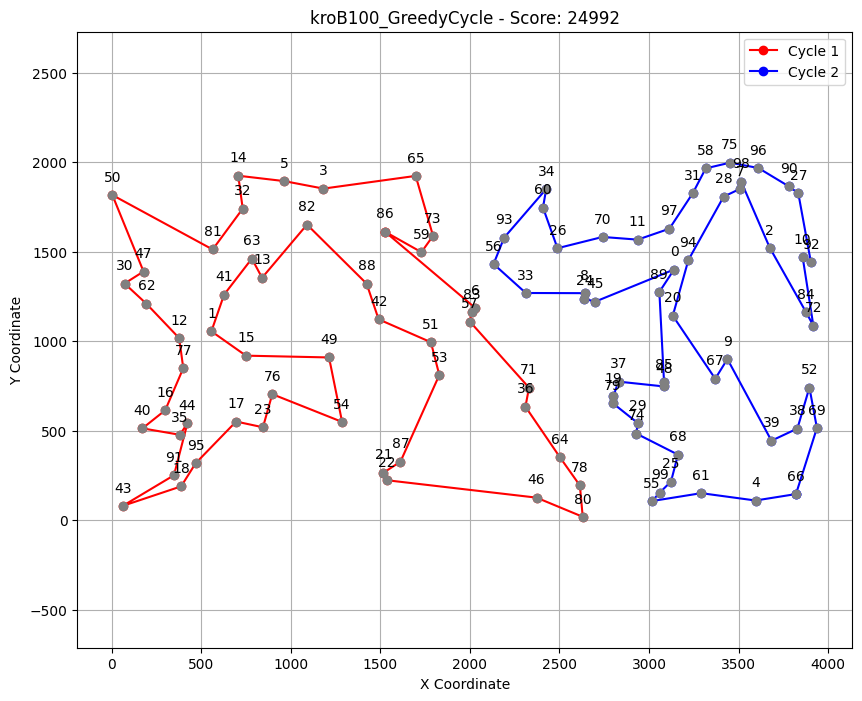

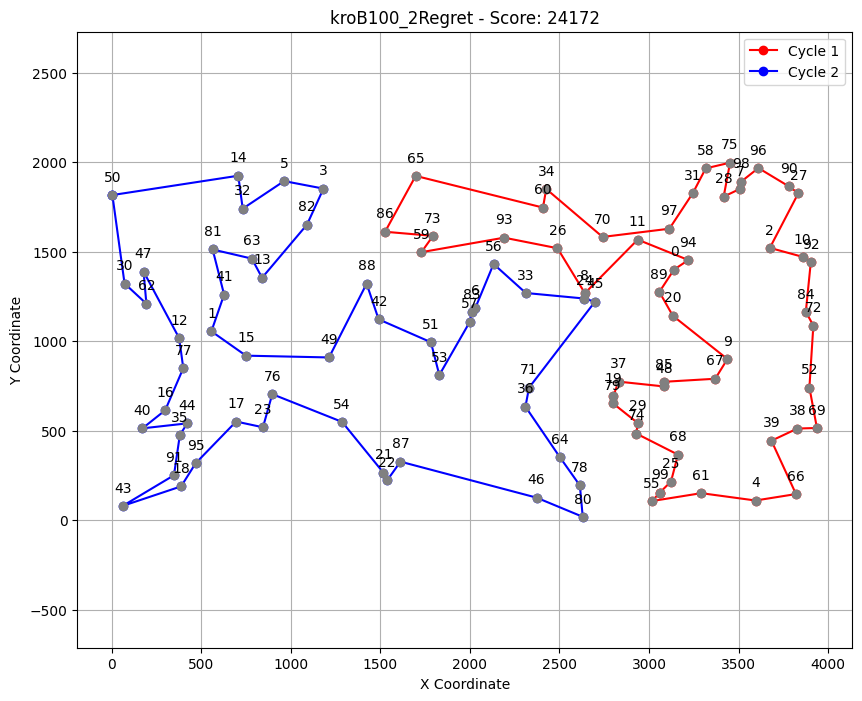

In [9]:
# Plottting best cycles
for instance, cycles in best_cycles.items():
    cycle1, cycle2, score = cycles
    coords = load_data(f'{instance.split("_")[0]}.tsp')
    plot_cycles(coords, cycle1, cycle2, title=f'{instance} - Score: {score}')
    